In [80]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import shape
import matplotlib.pyplot as plt
import sys
sys.path.append('../src/')
import image_coverage as img

In [20]:
df = pd.read_csv('../data/tf_cohort1/tm_api_tf_cohort1_2025-07-25.csv')

In [21]:
a = df.iloc[0]['geometry']
b = img.clean_geometry(a)

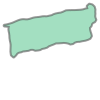

In [22]:
b

In [51]:
gdf = img.preprocess_polygons(df)

Processing polygon data...
Cleaning geometries...

🧾 Geometry Cleaning Summary:
  ➤ Total geometries processed: 13312
  ➤ Invalid geometries:         1
  ➤ Repaired with buffer(0):    0
  ➤ Dropped:                    1
  ✅ Final valid polygons:       13311



In [52]:
gdf.head(2)

,project_id,poly_id,site_id,poly_geom,plantstart,plantend,practice,target_sys,dist,project_phase,tree_cover,restoration_by_strategy,restoration_by_land_use,tree_cover_loss,tree_cover_loss_fires,restoration_by_ecoregion
0,47673f46-0af9-4047-afc7-b4f4fefaa5e7,7c19755d-0023-4558-a7b2-b345ca386915,5d55d6bc-1647-4eb9-a2bc-c36c1f5da5ab,"POLYGON ((33.69473 0.90355, 33.69473 0.90352, ...",2023-01-31,NaN,tree-planting,agroforest,partial,NaN,"{'indicatorSlug': 'treeCover', 'yearOfAnalysis...","{'indicatorSlug': 'restorationByStrategy', 'ye...","{'indicatorSlug': 'restorationByLandUse', 'yea...",NaN,NaN,NaN
1,47673f46-0af9-4047-afc7-b4f4fefaa5e7,ddb9d438-6d88-416d-8df1-3efd35f797a1,5d55d6bc-1647-4eb9-a2bc-c36c1f5da5ab,"POLYGON ((33.69295 0.90423, 33.69297 0.90423, ...",2023-01-31,NaN,tree-planting,agroforest,partial,NaN,"{'indicatorSlug': 'treeCover', 'yearOfAnalysis...","{'indicatorSlug': 'restorationByStrategy', 'ye...","{'indicatorSlug': 'restorationByLandUse', 'yea...",NaN,NaN,NaN


In [71]:
gdf_proj = gdf.to_crs("ESRI:102011")
gdf_proj["area_ha"] = gdf_proj.geometry.area / 10_000

In [72]:
# To display floats not in scientific notation
pd.options.display.float_format = '{:,.2f}'.format
# To reset
#pd.reset_option('display.float_format')

In [73]:
gdf_proj["area_ha"].describe()

count   13,311.00
mean         3.54
std         31.53
min          0.00
25%          0.24
50%          0.56
75%          1.11
max        979.29
Name: area_ha, dtype: float64

In [76]:
print('median:', gdf_proj["area_ha"].median())
print('mean:', gdf_proj["area_ha"].mean())

median: 0.5595979385402776
mean: 3.5391595396179993


<Axes: >

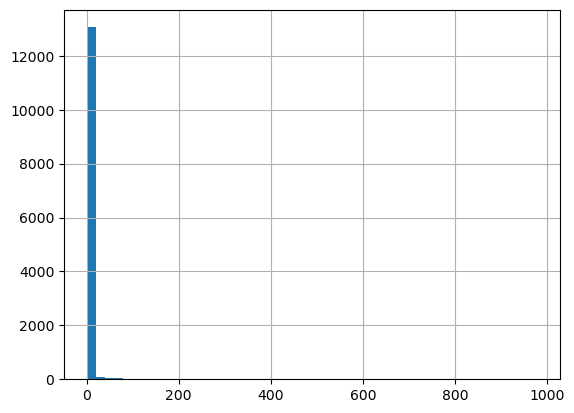

In [59]:
gdf_proj["area_ha"].hist(bins=50)

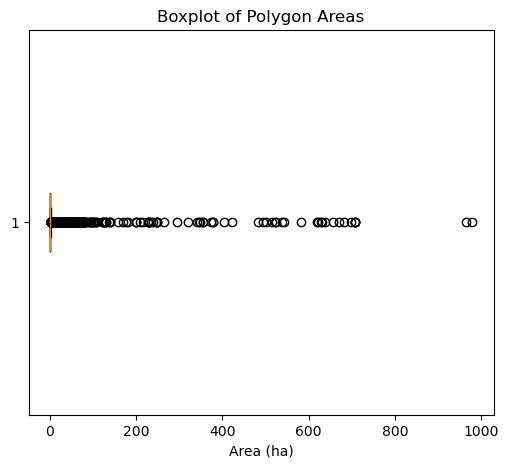

In [81]:
plt.figure(figsize=(6, 5))
plt.boxplot(gdf_proj["area_ha"].dropna(), vert=False, showfliers=True)
plt.xlabel("Area (ha)")
plt.title("Boxplot of Polygon Areas")
plt.show()

In [145]:
thresh = 10
n = len(gdf_proj[gdf_proj["area_ha"] < thresh])
p = (n / 13_113) * 100
print(f"{n} polyons ({p:,.2f}%) are <= {thresh} hectares")

12941 polyons (98.69%) are <= 10 hectares


In [123]:
gdf_proj[gdf_proj["area_ha"] > 900]

,project_id,poly_id,site_id,poly_geom,plantstart,plantend,practice,target_sys,dist,project_phase,tree_cover,restoration_by_strategy,restoration_by_land_use,tree_cover_loss,tree_cover_loss_fires,restoration_by_ecoregion,area_ha
910,2e2130be-7da7-4898-a9da-98ebb908cc96,dc5aec28-3a56-4c8a-bb44-720b43df39bd,49204e0a-0dcc-4865-a226-ded74e1074e6,"POLYGON ((2486802.802 106203.296, 2486550.704 ...",2022-01-12,NaN,assisted-natural-regeneration,silvopasture,NaN,NaN,"{'indicatorSlug': 'treeCover', 'yearOfAnalysis...","{'indicatorSlug': 'restorationByStrategy', 'ye...","{'indicatorSlug': 'restorationByLandUse', 'yea...",NaN,NaN,NaN,979.29
3775,0733b059-5538-4fd8-8c9a-7adb78aea248,108b2506-c0bd-423f-80fe-916087dfed72,61e40657-3b12-4b8a-8ec9-2c810aa65bf4,"POLYGON ((1343901.707 -1775223.816, 1343652.12...",2024-01-01,NaN,assisted-natural-regeneration,natural-forest,full,NaN,"{'indicatorSlug': 'treeCover', 'yearOfAnalysis...","{'indicatorSlug': 'restorationByStrategy', 'ye...","{'indicatorSlug': 'restorationByLandUse', 'yea...",NaN,NaN,NaN,963.92


In [160]:
total_area_per_proj = gdf_proj.groupby('project_id')['area_ha'].sum().reset_index()
total_area_per_proj

,project_id,area_ha
0,01918b25-6544-4027-82aa-6703c7c04784,87.47
1,0733b059-5538-4fd8-8c9a-7adb78aea248,"1,779.99"
2,128c2ac7-dd30-4093-a079-6e9111aa3351,610.07
3,12aefea5-2ec9-4181-93c3-2c739f7c8d64,74.84
4,16b297b3-30a3-4624-bcc9-4333919f66fc,97.01
...,...,...
76,f6075e7c-1d31-4bee-ba64-154cd664f7a1,96.37
77,f6ad3f9f-122b-4927-8c0c-de5576054f15,375.97
78,f81c1422-025c-45b1-a2e1-d354177523ca,"3,348.21"
79,f9dc4f5a-503b-45e5-baf0-0162f7bdb891,"1,125.08"


In [100]:
grouped_gdf.describe()
print('median:', grouped_gdf['area_ha'].median())
grouped_gdf.describe()

median: 147.75751858879673


,area_ha
count,81.00
mean,581.60
std,"1,534.17"
min,2.12
25%,74.84
50%,147.76
75%,404.62
max,"12,764.56"


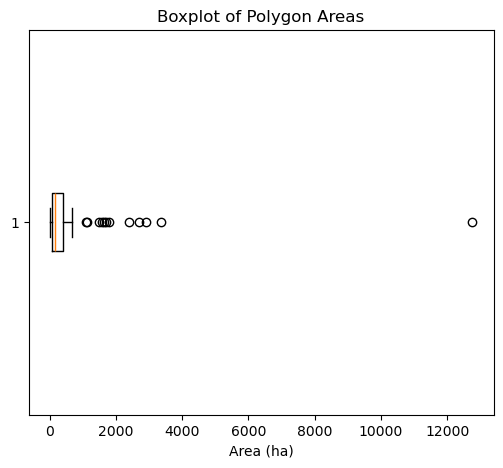

In [101]:
plt.figure(figsize=(6, 5))
plt.boxplot(grouped_gdf["area_ha"].dropna(), vert=False, showfliers=True)
plt.xlabel("Area (ha)")
plt.title("Boxplot of Polygon Areas")
plt.show()

- There are 13,311 polygons for 81 projects.
- 72 polygons are > 100 hectares (0.54%)
    - 99.5% of the polygons are < 100 hectares
- 134 polygons are > 50 hectares (1%)
    - 99% of polygons are < 50 hectares

- 74% of polygons (9639) are < 1 hectare

In [154]:
gdf_maj = gdf_proj[gdf_proj['area_ha'] <= 1]
gdf_small = gdf_proj[gdf_proj['area_ha'] <= 10]
gdf_big = gdf_proj[gdf_proj['area_ha'] > 10]

In [152]:
print('median:', gdf_maj['area_ha'].median())
gdf_maj['area_ha'].describe()

median: 0.36220146344088777


count   9,639.00
mean        0.41
std         0.28
min         0.00
25%         0.17
50%         0.36
75%         0.63
max         1.00
Name: area_ha, dtype: float64

In [153]:
print('median:', gdf_small['area_ha'].median())
gdf_small['area_ha'].describe()

median: 0.5365795062861928


count   12,941.00
mean         0.91
std          1.17
min          0.00
25%          0.23
50%          0.54
75%          1.02
max         10.00
Name: area_ha, dtype: float64

In [155]:
print('median:', gdf_big['area_ha'].median())
gdf_big['area_ha'].describe()

median: 29.975984827852756


count   370.00
mean     95.67
std     164.47
min      10.02
25%      16.61
50%      29.98
75%      74.85
max     979.29
Name: area_ha, dtype: float64